#Imports


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
np.random.seed(0)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

The MNIST database contains grayscale images of handwriting digits and their correct labels from 0 to 9.
The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255.

We will :

-Convert each image to float32

-Normalize them to [0, 1]

-Flatten them to a 1-D array of 784 features (28*28).

-Use one-hot encoding for the class element of each sample, 1 value for the index of the class value and 0 value for all the other classes

num_classes = 10 #total classes (0-9 digits)

num_features = 784 # data features (image shape: 28*28)

#Load and Prepare

In [2]:
def load_prepare_dataset():

    # Load the dataset
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    # Reshape/flatten the images
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

    # Use One-hot encoding to set exactly one of the positions in the vector to 1 (the correct digit) and the rest digits to 0
    num_classes = 10
    Y_train = to_categorical(Y_train,num_classes)
    Y_test = to_categorical(Y_test,num_classes)
    #print("First 5 training lables as one-hot encoded vectors:\n", Y_train[:5])

    # Convert from integer to float32
    X_train, X_test = np.array(X_train, np.float32), np.array(X_test, np.float32)

    # Normalize image values from [0, 255] to [0, 1] by dividing the pixel values with the maximum value
    X_train, X_test = (X_train / 255) , (X_test / 255)

    # Summarize the loaded dataset
    print('Number of images in Train sets: X = %s, Y = %s' % (X_train.shape, Y_train.shape))
    print('Number of images in Test sets: X = %s, Y =%s' % (X_test.shape, Y_test.shape))

    return X_train,Y_train,X_test,Y_test

# Call the function to load and prepare the dataset
X_train, Y_train, X_test, Y_test = load_prepare_dataset()


11490434/11490434 [==============================] - 0s 0us/step
Number of images in Train sets: X = (60000, 28, 28, 1), Y = (60000, 10)
Number of images in Test sets: X = (10000, 28, 28, 1), Y =(10000, 10)


#Visualize

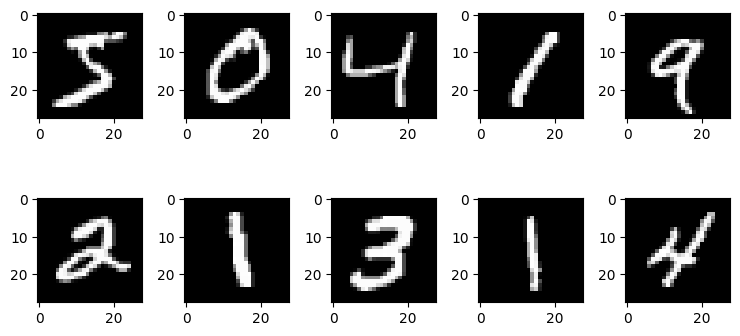

In [3]:
#Visualize data

num = 10
num_row = 2
num_col = 5
images = X_train[:num]

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
plt.tight_layout()
plt.show()

#Functions: Plot Loss and Accuracy results


In [4]:
# A function that plots the Loss and Accuracy

def show_train_history(train_history, train, validation):
    plt.plot( train_history.history[ train ])
    plt.plot( train_history.history[ validation ])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

#Functions: Adding callbacks

In [6]:
def callbacks(name):
  """
  EarlyStoping:Stop training when a monitored metric (here: loss) has stopped improving
  ReduceLROnPlateau class: reduces the learning rate when a metric (here: loss) has stopped improving
  ModelCheckpoint: saves the best model based on loss at the specified filepath
 """
  return [
        EarlyStopping(monitor = 'loss', patience = 6),
        ReduceLROnPlateau(monitor = 'loss', patience = 3),
        ModelCheckpoint(f'C:/Users/kleop/Documents/repos/{name}.hdf5', save_best_only=True) # saving the best model
    ]

#Functions:Evaluate model results

In [7]:
# A function that computes the accuracy and the confusion matrix of a model and prints the classification report
def evaluate_results(model, X_test, Y_test):
    # Evaluate the model's performance using the accuracy
    accuracy = model.evaluate(X_test, Y_test, verbose=1)
    print('Model evaluation:', accuracy)
    print()

    # Obtain predicted labels
    predictions = model.predict(X_test)
    Y_pred = np.argmax(predictions, axis=1)
    Y_true = np.argmax(Y_test, axis=1)

    # Create confusion matrix
    matrix = confusion_matrix(Y_true, Y_pred)

    # Plot confusion matrix as heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')
    plt.show()
    print()

    # Print classification report
    print('Classification report of Confusion matrix:\n', classification_report(Y_true, Y_pred))

#ANN

In [ ]:
def get_ann():
  """
  Sequential: means that each layer has exactly one input answer and one output answer
  Dropout:Regularization method:  30% of the neurons will be deactivated during training. Prevents the overfitting of the network.
  """
  return Sequential([
      Flatten(input_shape=(28,28)),
      Dense(256, input_dim =784 , activation='relu'),
      Dense(128, activation='relu'),
      Dropout(0.3),
      Dense(10, activation='softmax')
])

ann_model=get_ann()
ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ann_model.summary()
# The label is encoded with one hot and the loss of the model uses categorical cross entropy, a loss used when we're dealing with multiple classes


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


For the first layer: total number of weights= 784 (input shape) * 256 units + 256 (bias)= 200960 parameters

For the second layer: 256 *128 +128 (bias)= 32896

For the output layer: 128*10 +10=1290


#ANN_Train

In [ ]:
batch_size=32  #the higher the batch size, the more space you need in the memory
train_history_ann = ann_model.fit(X_train, Y_train, epochs = 10, batch_size = batch_size, validation_split = 0.1, verbose = 1,callbacks = callbacks('ann'))
#In the training set :The loss goes down in every iteration and the accuracy goes up in every iteration, which is what we want. We reach an over 99% accuracy on the training set!
#The validation set reaches an accuracy of around 98%, whereas the validation loss does not show a stable decrease

Epoch 1/10
1688/1688 [==============================] - 12s 4ms/step - loss: 0.2570 - accuracy: 0.9225 - val_loss: 0.1093 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 2/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.1104 - accuracy: 0.9671 - val_loss: 0.0824 - val_accuracy: 0.9752 - lr: 0.0010
Epoch 3/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0781 - accuracy: 0.9763 - val_loss: 0.0810 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 4/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0587 - accuracy: 0.9813 - val_loss: 0.0833 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 5/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0477 - accuracy: 0.9843 - val_loss: 0.0721 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 6/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0393 - accuracy: 0.9874 - val_loss: 0.0684 - val_accuracy: 0.9822 - lr: 0.0010
Epoch 7/10
1688/1688 [==============================] - 6

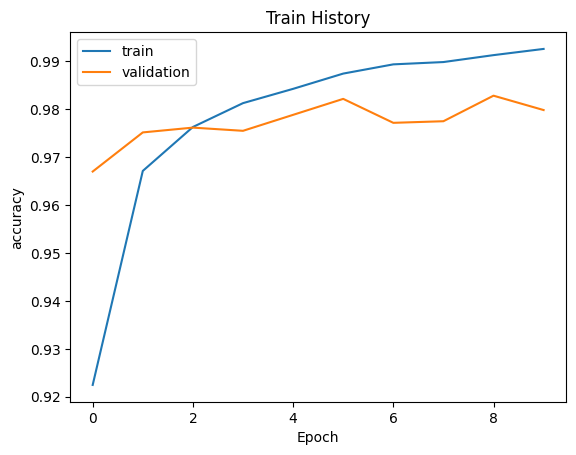

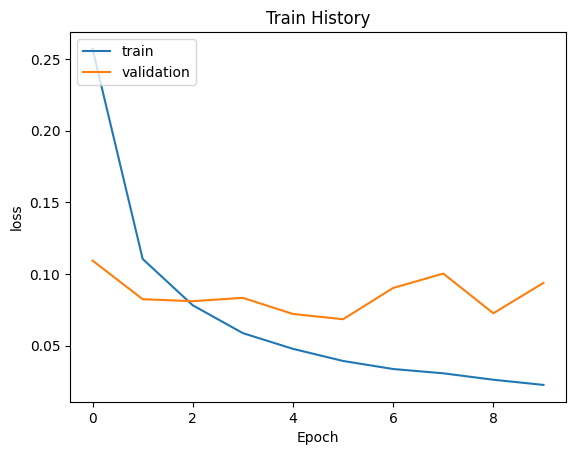

In [ ]:
show_train_history(train_history_ann,'accuracy', 'val_accuracy')
show_train_history(train_history_ann,'loss', 'val_loss')

313/313 [==============================] - 1s 3ms/step - loss: 0.1019 - accuracy: 0.9785
Model evaluation: [0.10193338245153427, 0.9785000085830688]

313/313 [==============================] - 1s 1ms/step


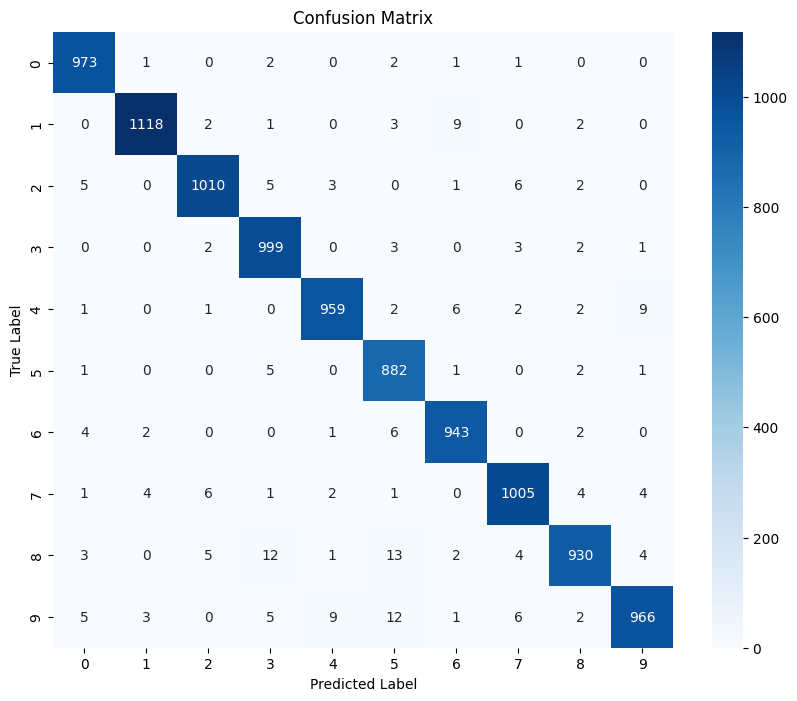


Classification report of Confusion matrix:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.95      0.99      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.95      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
evaluate_results(ann_model,X_test,Y_test)

#Pedict 1 image from test set

In [ ]:
y_pred = ann_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred)
print(y_pred_classes)

313/313 [==============================] - 0s 1ms/step
[[2.4288637e-17 2.2790828e-10 5.6915646e-11 ... 1.0000000e+00
  1.1356026e-14 1.8976098e-10]
 [9.2814588e-17 1.6332029e-08 1.0000000e+00 ... 3.2540026e-15
  3.6710123e-17 2.0385583e-21]
 [2.6819190e-08 9.9998343e-01 6.7759020e-06 ... 9.5091764e-07
  5.5125524e-06 3.0102829e-08]
 ...
 [6.5249609e-19 5.3977475e-15 2.4119499e-16 ... 3.7958567e-11
  5.8004507e-13 1.1760261e-09]
 [1.5271728e-26 7.2192803e-26 3.7309479e-29 ... 4.3743599e-25
  9.4019420e-17 1.8091973e-24]
 [1.3552709e-14 8.8696038e-27 2.8413489e-19 ... 3.2461811e-29
  4.4315579e-21 7.3221331e-23]]
[7 2 1 ... 4 5 6]


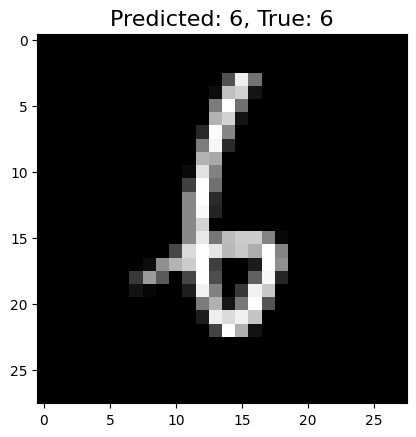

In [ ]:
# Single Example
random_idx = np.random.choice(len(X_test))
x_sample = X_test[random_idx]
y_true = np.argmax(Y_test, axis=1)
y_sample_true = y_true[random_idx]
y_sample_pred_class = y_pred_classes[random_idx]

plt.title("Predicted: {}, True: {}".format(y_sample_pred_class, y_sample_true), fontsize=16)
plt.imshow(x_sample.reshape(28, 28), cmap='gray')

#Investigate some errors in ANN_Model

In [ ]:
errors = (y_pred_classes - y_true != 0)
y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_test_errors = X_test[errors]


In [ ]:
y_pred_errors_probability = np.max(y_pred_errors, axis=1)
true_probability_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))
diff_errors_pred_true = y_pred_errors_probability - true_probability_errors

# Get list of indices of sorted differences
sorted_idx_diff_errors = np.argsort(diff_errors_pred_true)
top_idx_diff_errors = sorted_idx_diff_errors[-5:] # 5 last ones

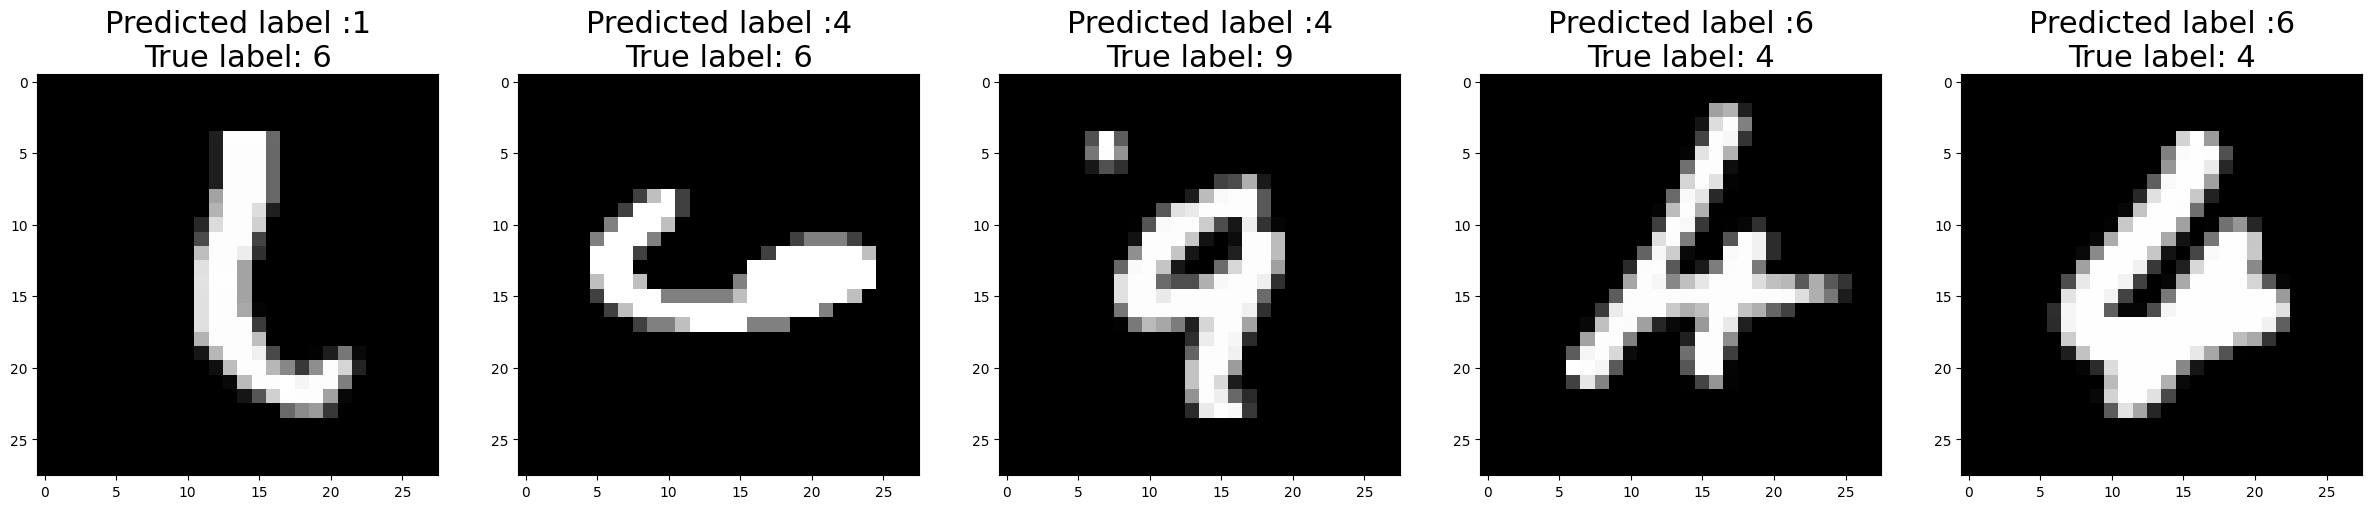

In [ ]:
# Show Top Errors
num = len(top_idx_diff_errors)
f, ax = plt.subplots(1, num, figsize=(30,30))

for i in range(0, num):
  idx = top_idx_diff_errors[i]
  sample = x_test_errors[idx].reshape(28,28)
  y_t = y_true_errors[idx]
  y_p = y_pred_classes_errors[idx]
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("Predicted label :{}\nTrue label: {}".format(y_p, y_t), fontsize=22)



 From the indicated error above, we see the model is struggling in discerning the digit 6 from the digit 4 and vice versa. Still the errors we see, could be done by humans too, so we can say we made a good start with the ANN.

#CNN (including the Bonus part: Max pooling after each conv layer)

Each Convolutional layer consists of a set of filters and each filert can detect a specific pattern. We will use a 3x3 filer(kernel) on each layer.

(28x28x1) - (26x26x64) due to the border-effect- (13x13x64)-(11x11x32)- (5x5x32)-flatten (800x1)-(800x128+128=102528)-(128x10+10=1290)


In [9]:
def get_cnn():
  """
  Padding='same': by setting this paraemeter we avoid the border effect that reduces the dimensions of the imput, so we do not lose information.
  MaxPooling2D:Get the maximum value from each block of 2x2, so the output will be 14x14
  """
  return Sequential([
         Conv2D(64, kernel_size=(3, 3), padding='same', input_shape = (28,28,1)),
         MaxPooling2D(pool_size=(2, 2)),
         Conv2D(32, kernel_size=(3, 3)),
         MaxPooling2D(pool_size=(2, 2)),
         Flatten(),
         Dense(128, activation='relu'),
         Dropout(0.5),
         Dense(10, activation = "softmax")

])




In [10]:
cnn_model = get_cnn()
cnn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 128)               1

#Train CNN

In [11]:
train_history_cnn=cnn_model.fit(X_train, Y_train, epochs = 10, batch_size = 32, validation_split = 0.1, verbose = 1, callbacks = callbacks('cnn_v1'))

Epoch 1/10
1688/1688 [==============================] - 25s 6ms/step - loss: 0.2369 - accuracy: 0.9274 - val_loss: 0.0548 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 2/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0973 - accuracy: 0.9714 - val_loss: 0.0471 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 3/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0766 - accuracy: 0.9767 - val_loss: 0.0409 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 4/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0612 - accuracy: 0.9809 - val_loss: 0.0363 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 5/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0565 - accuracy: 0.9823 - val_loss: 0.0337 - val_accuracy: 0.9920 - lr: 0.0010
Epoch 6/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0505 - accuracy: 0.9843 - val_loss: 0.0368 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 7/10
1688/1688 [==============================] -

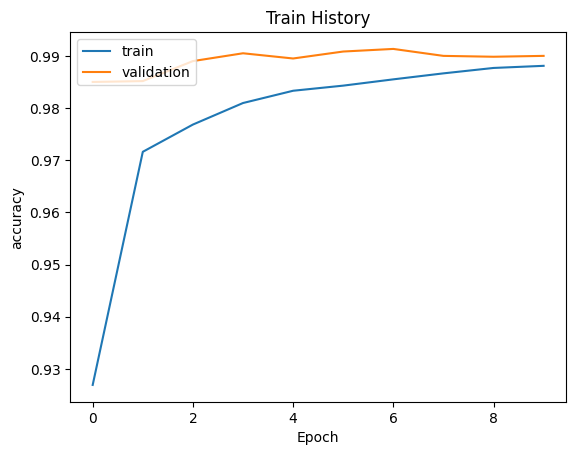

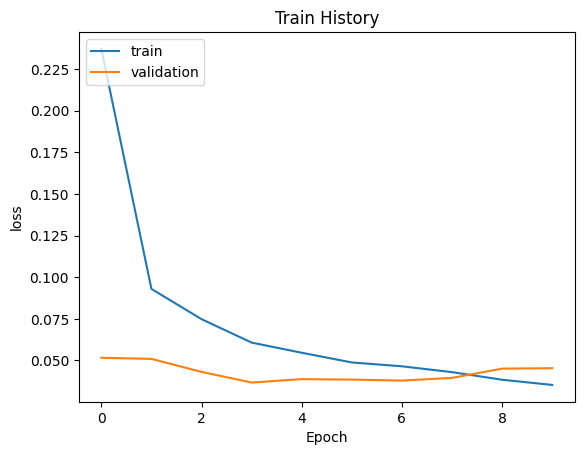

In [ ]:
show_train_history(train_history_cnn,'accuracy', 'val_accuracy')
show_train_history(train_history_cnn,'loss', 'val_loss')

We see the validation set performed better in the CNN rather than the ANN.And from the confusion matrix below, we confirm that the CNN gave an accuracy of almost 99% in unseen data! The difference though of the 2 models is not significant.

313/313 [==============================] - 2s 5ms/step - loss: 0.0390 - accuracy: 0.9890
Model evaluation: [0.03899185732007027, 0.9890000224113464]

313/313 [==============================] - 1s 3ms/step


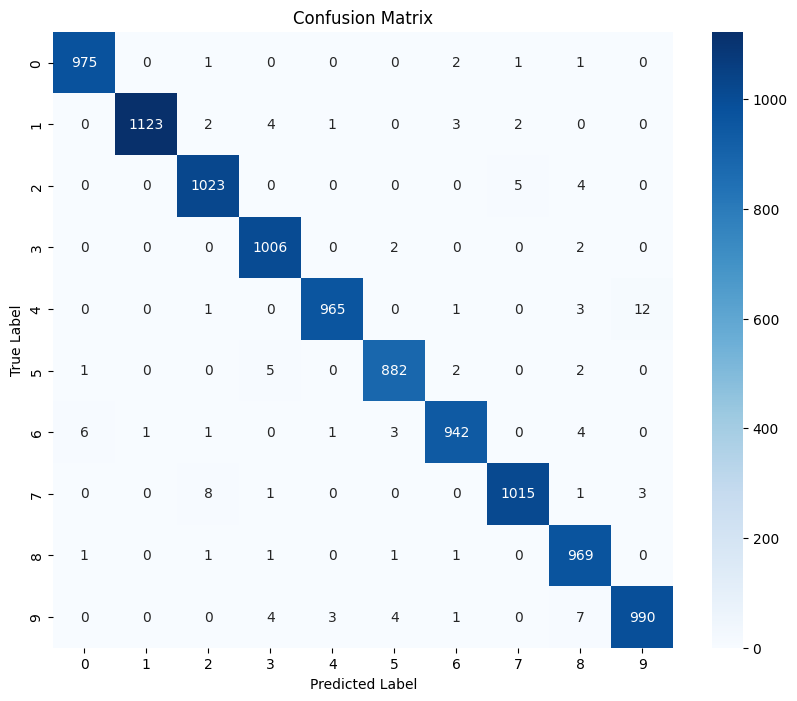


Classification report of Confusion matrix:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
evaluate_results(cnn_model,X_test,Y_test)

The difference between the 2 models can be because of the difference between densely connected layers and convolutional layers and the level of complexity of the two.
Dense layers: Can only learn from the global patters of all pixels.
Whereas,
Convolutional layers:Can learn from the local patterns. That means , they can pay attention to the shape of the edges to the vertical or horizontal lines and then recognize that shape everywhere they find it.

Also, in the ANNs since we flatten all features(pixels) we lose the notion of the 'spatial neighborhood' of the pixels, which in the CNN is kept, because the feature extraction process is embodied in the training process.

Nevertheless, it's worth noting that the CNN due to its higher complexity, used more computational time for training.

#Investigate some errors in CNN_Model

In [13]:
y_pred_cnn = cnn_model.predict(X_test)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
print(y_pred_cnn)
print(y_pred_classes_cnn)

313/313 [==============================] - 1s 5ms/step
[[1.7769828e-15 1.0618691e-10 5.4173551e-11 ... 1.0000000e+00
  1.0883647e-12 2.7129654e-09]
 [8.7780290e-09 8.4251876e-11 1.0000000e+00 ... 5.7438532e-16
  9.1540257e-18 1.6044958e-21]
 [4.4197634e-10 9.9999964e-01 3.4473995e-09 ... 1.1191219e-08
  3.4757289e-10 1.8683087e-12]
 ...
 [7.3493855e-24 2.6295183e-15 5.0704360e-18 ... 2.8159005e-15
  9.3818877e-15 1.5586776e-12]
 [3.7497069e-16 9.6128934e-19 6.1249994e-21 ... 2.4559616e-21
  4.7411458e-10 3.9559178e-17]
 [4.6571857e-09 1.1692465e-17 9.5441615e-12 ... 5.3464787e-21
  1.7609579e-13 1.9275148e-14]]
[7 2 1 ... 4 5 6]


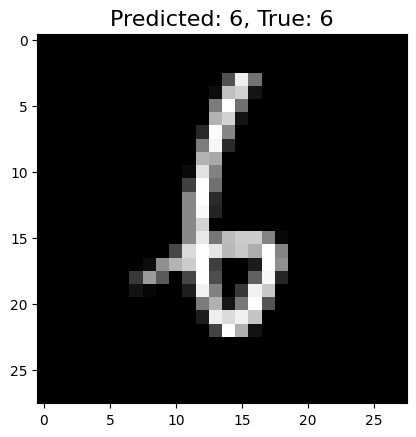

In [14]:
# Single Example
random_idx = np.random.choice(len(X_test))
x_sample = X_test[random_idx]
y_true = np.argmax(Y_test, axis=1)
y_sample_true = y_true[random_idx]
y_sample_pred_class = y_pred_classes_cnn[random_idx]

plt.title("Predicted: {}, True: {}".format(y_sample_pred_class, y_sample_true), fontsize=16)
plt.imshow(x_sample.reshape(28, 28), cmap='gray')

In [15]:
errors = (y_pred_classes_cnn - y_true != 0)
y_pred_classes_errors = y_pred_classes_cnn[errors]
y_pred_errors = y_pred_cnn[errors]
y_true_errors = y_true[errors]
x_test_errors = X_test[errors]

In [16]:
y_pred_errors_probability = np.max(y_pred_errors, axis=1)
true_probability_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))
diff_errors_pred_true = y_pred_errors_probability - true_probability_errors

# Get list of indices of sorted differences
sorted_idx_diff_errors = np.argsort(diff_errors_pred_true)
top_idx_diff_errors = sorted_idx_diff_errors[-5:] # 5 last ones

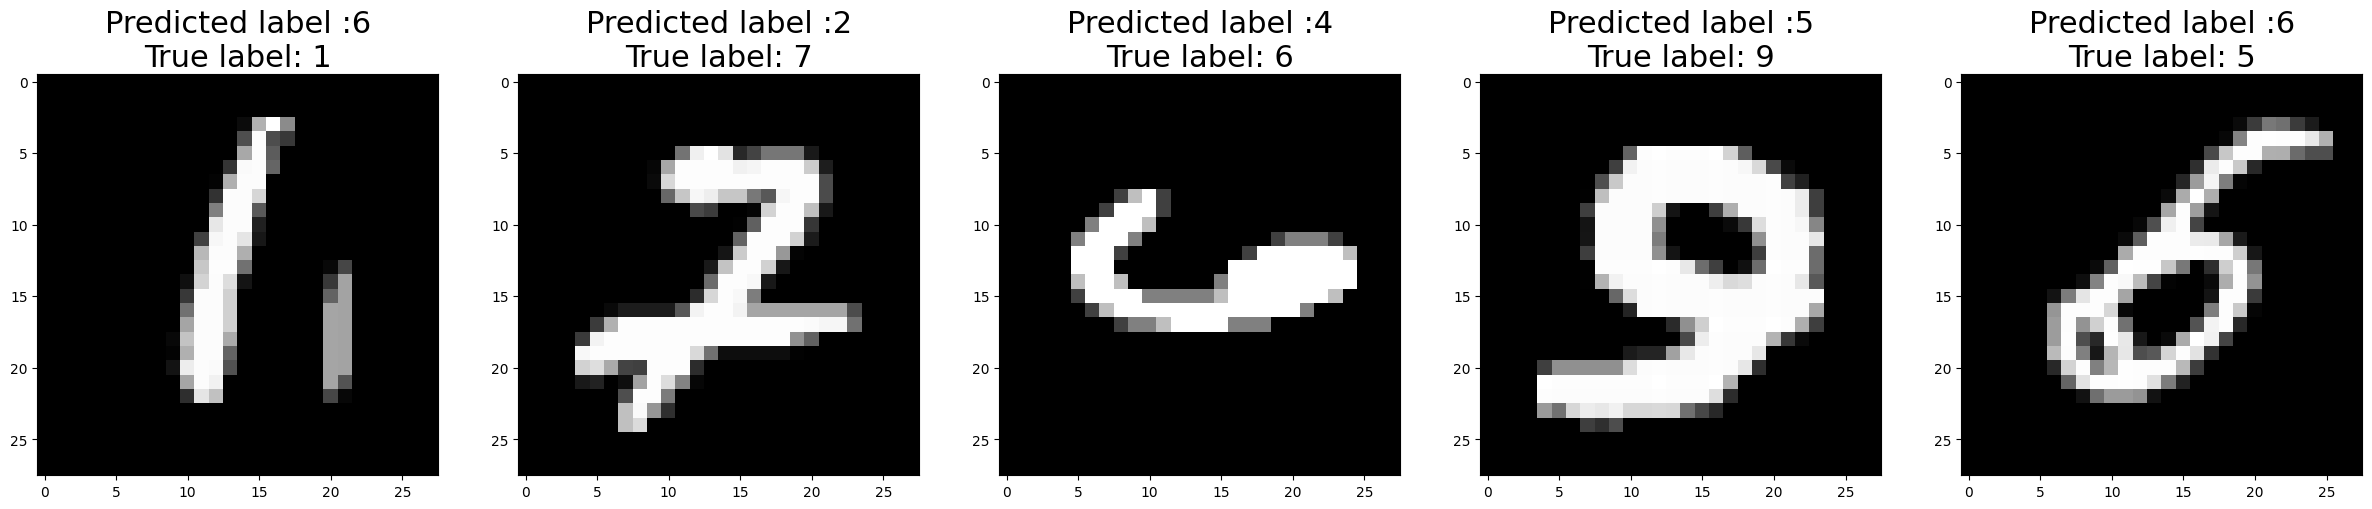

In [17]:
# Show Top Errors
num = len(top_idx_diff_errors)
f, ax = plt.subplots(1, num, figsize=(30,30))

for i in range(0, num):
  idx = top_idx_diff_errors[i]
  sample = x_test_errors[idx].reshape(28,28)
  y_t = y_true_errors[idx]
  y_p = y_pred_classes_errors[idx]
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("Predicted label :{}\nTrue label: {}".format(y_p, y_t), fontsize=22)

#Experiment:Building new model and using batch normalization

To solve the slowlier traiing speed of the CNN we will apply batch normalization.In batch-normalisation we normalize each layer’s inputs by using the mean and variance of the values in the current mini-batch.
The CNN was constructed on the following pattern:

-After 2 2D-convolutional layers of 32 kernels each and filter size 3x3 each,I apply Batch normalisation,max pooling (2x2) and apply a dropout of 25% of the neurons to prevent overfitting.

-Repeat the same process, this time my 2 2D convolutional layers consist of 64 kernels each (so i doubled the size of the kernels at each layer)

-Repeat the same process, this time my 2 2D convolutional layers consist of 128 kernels each (so again, i doubled the size of the kernels at each layer)

-At every convolutional layer, I set the padding='same', so that i do not lose dimensions and information, so the only dimensionality reduction comes from the max-pooling

-Then I flatten the feature vector (after the last max_pooling, I reached the 3x3 dimensions, so the flattened vector has (3x3x128=1152) parameters
-Then I add a fully connected layer of 64 neurons, apply batch normalisation and a dropout of 30%.

All layers convolutional and fully connected use ReLU activation function, exept of the output layer that uses softmax.

In [ ]:
def get_cnn_v2():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape =(28,28,1)),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation = "softmax")

    ])

In [ ]:
model_cnn2 = get_cnn_v2()
model_cnn2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_cnn2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 14, 14, 64)       

In [ ]:
train_history_cnn2=model_cnn2.fit(X_train, Y_train, epochs = 15, batch_size = 100, validation_split = 0.1, verbose = 1,callbacks = callbacks('best_cnn'))

Epoch 1/15
540/540 [==============================] - 12s 13ms/step - loss: 0.2306 - accuracy: 0.9325 - val_loss: 0.1260 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 2/15
540/540 [==============================] - 6s 12ms/step - loss: 0.0650 - accuracy: 0.9805 - val_loss: 0.0425 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 3/15
540/540 [==============================] - 6s 12ms/step - loss: 0.0475 - accuracy: 0.9856 - val_loss: 0.0279 - val_accuracy: 0.9915 - lr: 0.0010
Epoch 4/15
540/540 [==============================] - 6s 12ms/step - loss: 0.0391 - accuracy: 0.9885 - val_loss: 0.0283 - val_accuracy: 0.9915 - lr: 0.0010
Epoch 5/15
540/540 [==============================] - 7s 12ms/step - loss: 0.0328 - accuracy: 0.9898 - val_loss: 0.0220 - val_accuracy: 0.9935 - lr: 0.0010
Epoch 6/15
540/540 [==============================] - 6s 12ms/step - loss: 0.0311 - accuracy: 0.9903 - val_loss: 0.0234 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 7/15
540/540 [==============================] - 6s 12ms/s

In [ ]:
model = load_model('C:/Users/kleop/Documents/repos/best_cnn.hdf5')

313/313 [==============================] - 2s 4ms/step - loss: 0.0180 - accuracy: 0.9943
Model evaluation: [0.017956970259547234, 0.9943000078201294]

313/313 [==============================] - 1s 3ms/step


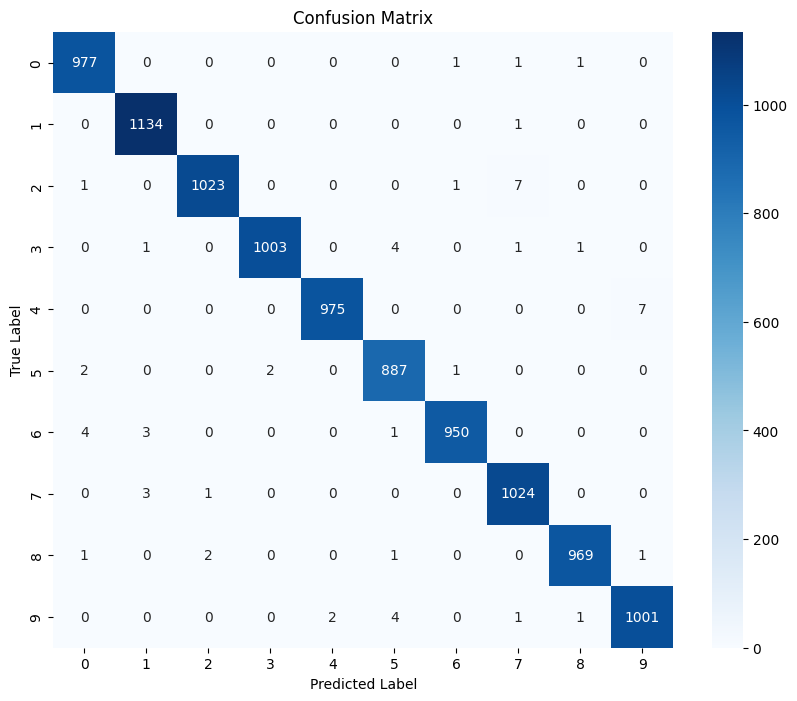


Classification report of Confusion matrix:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       1.00      0.99      1.00      1010
           4       1.00      0.99      1.00       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
evaluate_results(model,X_test,Y_test)

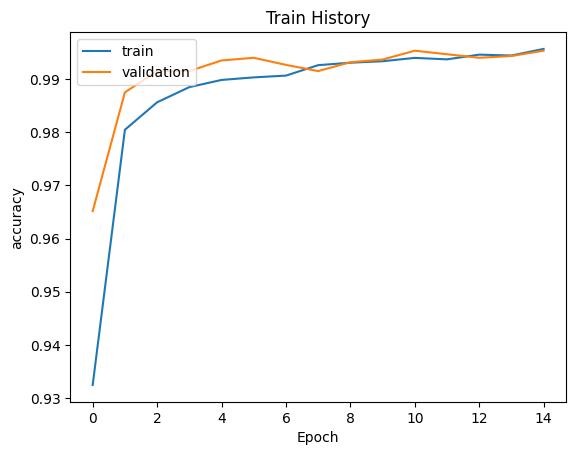

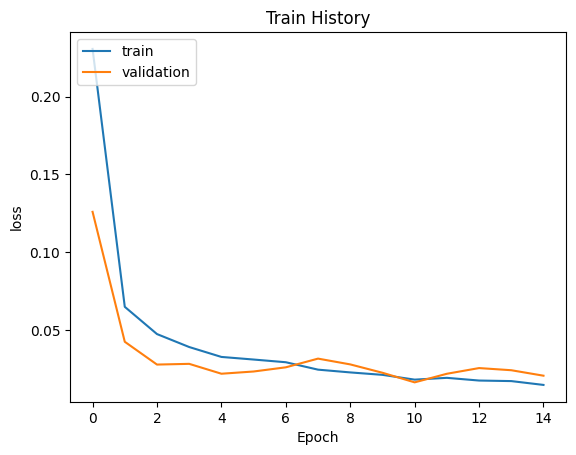

In [ ]:
show_train_history(train_history_cnn2, 'accuracy', 'val_accuracy')
show_train_history(train_history_cnn2, 'loss', 'val_loss')

The batch normalisation process after each 2 conv layers and the dense layer, did help the model in terns of:

1)Speed acceleration: We increased the batch size and the number of epochs. Each training iteration was actually  slower because of the extra calculations during the forward pass and the additional hyperparameters to train during back propagation. However, the network converged much more quickly, so training was faster overall.

2)Building a deeper network: We used way more convolutional layers compared to the first CNN.

3)Learning curve Optimisation: the convergence of the learning curves of the train and the validation set improved siginficantly compared to the previous 2 models.The second version of cnn model seems a good fit as the curve of the training loss was quite high and decreased drammatically to a point of stability . The curve of the validation loss was also high but decreased dramatically and has a very small gap with the curve of the training loss.

4)Producing better results in unseen data: We reached an accuracy of over 99% in the test set!
